In [153]:
import os
import sys
import xarray as xr
import numpy as np
import pandas as pd
import subprocess
from pycpt_functions_seasonal import *
from scipy.stats import t
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

In [156]:
def pltprobff(models,predictand,thrs,ntrain,lon,lat,loni,lone,lati,late,fprefix,mpref,monf,fyr,mons,tgts):
	"""A simple function for ploting probabilities of exceedance and PDFs (for a given threshold)

	PARAMETERS
	----------
		thrs: the threshold, in the units of the predictand
		lon: longitude
		lat: latitude
	"""
	#Implement: read degrees of freedom from CPT file
	#Formally, for CCA, dof=ntrain - #CCAmodes -1 ; since ntrain is huge after concat, dof~=ntrain for now
	dof=ntrain
	tar=tgts[mons.index(monf)]
	#Read grads binary file size H, W   
	with open('/Users/agmunoz/Documents/Angel/Publics/Aedes_USA_R0/Calculations/CPToutput/'+models[0]+'_FCST_mu_ini'+monf+'_'+str(fyr)+'.ctl', "r") as fp:
		for line in lines_that_contain("XDEF", fp):
			W = int(line.split()[1])
			XD= float(line.split()[4])
	with open('/Users/agmunoz/Documents/Angel/Publics/Aedes_USA_R0/Calculations/CPToutput/'+models[0]+'_FCST_mu_ini'+monf+'_'+str(fyr)+'.ctl', "r") as fp:
		for line in lines_that_contain("YDEF", fp):
			H = int(line.split()[1])
			YD= float(line.split()[4])
	with open('/Users/agmunoz/Documents/Angel/Publics/Aedes_USA_R0/Calculations/CPToutput/'+models[0]+'_FCST_Obs_ini'+monf+'_'+str(fyr)+'.ctl', "r") as fp:
		for line in lines_that_contain("TDEF", fp):
			T = int(line.split()[1])
			TD= 1  #not used

	#Find the gridbox:
	lonrange = np.linspace(loni, loni+W*XD,num=W)
	latrange = np.linspace(lati+H*YD, lati, num=H)  #need to reverse the latitudes because of CPT (GrADS YREV option)
	lon_grid, lat_grid = np.meshgrid(lonrange, latrange)
	a = abs(lat_grid-lat)+abs(lon_grid-lon)
	i,j = np.unravel_index(a.argmin(),a.shape)   #i:latitude   j:longitude

	#Now compute stuff and plot
	plt.figure(figsize=(15,15))

	k=0
	for model in models:
		k=k+1
		#Forecast files--------
		#Read mean
		#Since CPT writes grads files in sequential format, we need to excise the 4 bytes between records (recl)
		f=open('/Users/agmunoz/Documents/Angel/Publics/Aedes_USA_R0/Calculations/CPToutput/'+model+'_FCST_mu_ini'+monf+'_'+str(fyr)+'.dat','rb')
		recl=struct.unpack('i',f.read(4))[0]
		numval=int(recl/np.dtype('float32').itemsize)
		#Now we read the field
		A=np.fromfile(f,dtype='float32',count=numval)
		muf = np.transpose(A.reshape((W, H), order='F'))
		muf[muf==-999.]=np.nan #only sensible values
		muf=muf[i,j]

		#Read variance
		f=open('/Users/agmunoz/Documents/Angel/Publics/Aedes_USA_R0/Calculations/CPToutput/'+model+'_FCST_var_ini'+monf+'_'+str(fyr)+'.dat','rb')
		recl=struct.unpack('i',f.read(4))[0]
		numval=int(recl/np.dtype('float32').itemsize)
		#Now we read the field
		A=np.fromfile(f,dtype='float32',count=numval)
		varf = np.transpose(A.reshape((W, H), order='F'))
		varf[varf==-999.]=np.nan #only sensible values
		varf=varf[i,j]/1000

		#Obs file--------
		#Compute obs mean and variance.
		#
		muc0=np.empty([T,H,W])  #define array for later use
		#Since CPT writes grads files in sequential format, we need to excise the 4 bytes between records (recl)
		f=open('/Users/agmunoz/Documents/Angel/Publics/Aedes_USA_R0/Calculations/CPToutput/'+model+'_FCST_Obs_ini'+monf+'_'+str(fyr)+'.dat','rb')
		#cycle for all time steps  (same approach to read GrADS files as before, but now read T times)
		for it in range(T):
			#Now we read the field
			recl=struct.unpack('i',f.read(4))[0]
			numval=int(recl/np.dtype('float32').itemsize) #this if for each time stamp
			A0=np.fromfile(f,dtype='float32',count=numval)
			endrec=struct.unpack('i',f.read(4))[0]  #needed as Fortran sequential repeats the header at the end of the record!!!
			muc0[it,:,:]= np.transpose(A0.reshape((W, H), order='F'))

		muc0[muc0==-999.]=np.nan #identify NaNs
		muc=np.nanmean(muc0, axis=0)  #axis 0 is T
		#Compute obs variance
		varc=np.nanvar(muc0, axis=0)  #axis 0 is T
		#Select gridbox values
		muc=muc[i,j]
		#print(muc)   #Test it's actually zero
		varc=varc[i,j]

		#Compute scale parameter for the t-Student distribution
		scalef=np.sqrt(dof*varf)   #due to transformation from Gamma
		scalec=np.sqrt((dof-2)/dof*varc)

		x = np.linspace(min(t.ppf(0.0001, dof, loc=muf, scale=scalef),t.ppf(0.0001, dof, loc=muc, scale=scalec)),max(t.ppf(0.9999, dof, loc=muf, scale=scalef),t.ppf(0.9999, dof, loc=muc, scale=scalec)), 100)
		style = dict(size=10, color='black')

		#cprob = special.erfc((x-muc)/scalec)
		cprob = exceedprob(thrs,dof,muc,scalec)
		fprob = exceedprob(thrs,dof,muf,scalef)
		cprobth = round(t.sf(thrs, dof, loc=muc, scale=scalec)*100,2)
		fprobth = round(t.sf(thrs, dof, loc=muf, scale=scalef)*100,2)
		cpdf=t.pdf(x, dof, loc=muc, scale=scalec)*100
		fpdf=t.pdf(x, dof, loc=muf, scale=scalef)*100
		oddsrc =(fprobth/cprobth)

		fig, ax = plt.subplots(1, 2,figsize=(12,4))
		#font = {'family' : 'Palatino',
		#        'size'   : 16}
		#plt.rc('font', **font)
		#plt.rc('text', usetex=True)
		#plt.rc('font', family='serif')

		plt.subplot(1, 2, 1)
		plt.plot(x, t.sf(x, dof, loc=muc, scale=scalec)*100,'b-', lw=5, alpha=0.6, label='clim')
		plt.plot(x, t.sf(x, dof, loc=muf, scale=scalef)*100,'r-', lw=5, alpha=0.6, label='fcst')
		plt.axvline(x=thrs, color='k', linestyle='--')
		plt.plot(thrs, fprobth,'ok')
		plt.plot(thrs, cprobth,'ok')
		plt.text(thrs+0.05, cprobth, str(cprobth)+'%', **style)
		plt.text(thrs+0.05, fprobth, str(fprobth)+'%', **style)
		#plt.text(0.1, 10, r'$\frac{P(fcst)}{P(clim)}=$'+str(round(oddsrc,1)), **style)
		plt.text(min(t.ppf(0.0001, dof, loc=muf, scale=scalef),t.ppf(0.0001, dof, loc=muc, scale=scalec)), -20, 'P(fcst)/P(clim)='+str(round(oddsrc,1)), **style)
		plt.legend(loc='best', frameon=False)
		# Add title and axis names
		plt.title(model)
		plt.xlabel('R0')
		plt.ylabel('Probability (%)')
		# Limits for the Y axis
		plt.xlim(min(t.ppf(0.01, dof, loc=muf, scale=scalef),t.ppf(0.01, dof, loc=muc, scale=scalec)),max(t.ppf(0.9999, dof, loc=muf, scale=scalef),t.ppf(0.9999, dof, loc=muc, scale=scalec)))

		plt.subplot(1, 2, 2)
		plt.plot(x, cpdf,'b-', lw=5, alpha=0.6, label='clim')
		plt.plot(x, fpdf,'r-', lw=5, alpha=0.6, label='fcst')
		plt.axvline(x=thrs, color='k', linestyle='--')
		plt.legend(loc='best', frameon=False)
		# Add title and axis names
		plt.title('Probability Density Functions')
		plt.xlabel('R0')
		plt.ylabel('')
		# Limits for the Y axis
		plt.xlim(min(t.ppf(0.00001, dof, loc=muf, scale=scalef),t.ppf(0.00001, dof, loc=muc, scale=scalec)),max(t.ppf(0.9999, dof, loc=muf, scale=scalef),t.ppf(0.9999, dof, loc=muc, scale=scalec)))


	plt.subplots_adjust(hspace=0)
	plt.subplots_adjust(bottom=0.15, top=0.9)
	#cax = plt.axes([0.2, 0.08, 0.6, 0.04])
	#cbar = plt.colorbar(CS,cax=cax, orientation='horizontal')
	#cbar.set_label(label) #, rotation=270)
	f.close()

<Figure size 1080x1080 with 0 Axes>

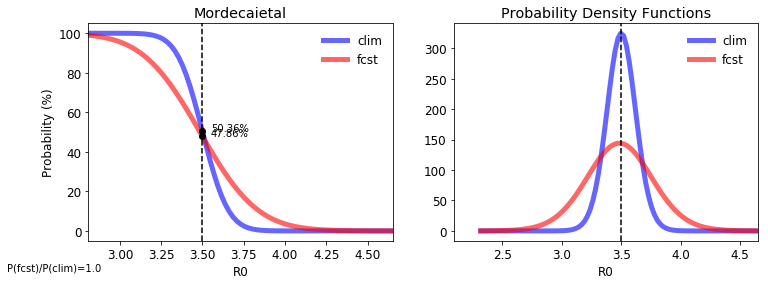

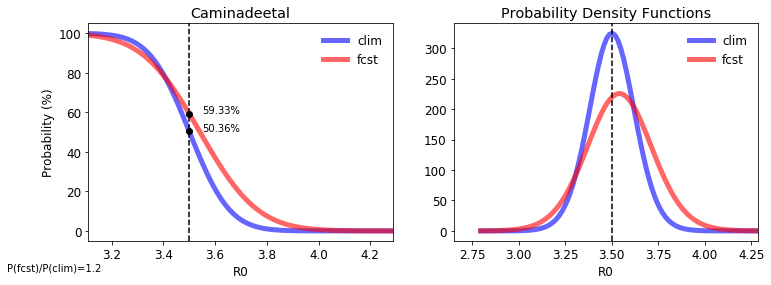

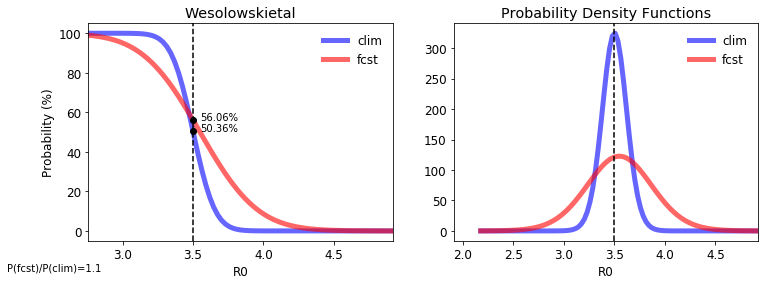

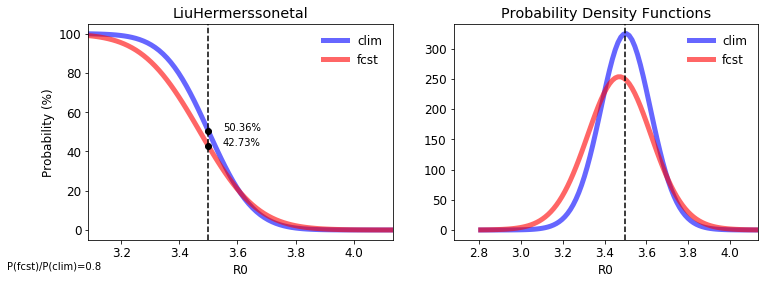

In [160]:
models=['Mordecaietal', 'Caminadeetal', 'Wesolowskietal', 'LiuHermerssonetal']
flexformat_threshold = 3.5 #threshold for the flexible format map --here is just a scalar (only one target season)
ffthres_ispctl=False  #If True, flex format threshold is a percentile: 0.001 - 0.999
# ########Spatial domain for predictor
nla1=49 	# Northernmost latitude
sla1=0 	# Southernmost latitude
wlo1=-125 	# Westernmost longitude
elo1=-41 	# Easternmost longitude
# Spatial domain for predictand
nla2=49 	# Northernmost latitude
sla2=0 	# Southernmost latitude
wlo2=-125 	# Westernmost longitude
elo2=-41 	# Easternmost longitude
lon=-72.
lat=11.
PREDICTAND='dumb'
fprefix='dumb'
mpref='dumb'
########Target seasons and related parameters
##If more targets, increase the arrays accordingly
#mons=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
mons=['May']
tgti='1.5'  #S: start for the DL
tgtf='3.5'   #S: end for the DL
#for now, just write the target period (for DL)
#tgts=['Feb-Apr','Mar-May','Apr-Jun','May-Jul','Jun-Aug','Jul-Sep','Aug-Oct','Sep-Nov','Oct-Dec','Nov-Jan','Dec-Feb','Jan-Mar'] 
tgts=['Jun-Aug']
L=['1'] #lead for file name (it depends on how the DL has been configured in the country)
ntrain=29 # length of training period (1982-2009)
fyr=2016
monf='May'
plt.rcParams.update({'font.size': 12})
pltprobff(models,PREDICTAND,flexformat_threshold,ntrain,lon,lat,wlo2,elo2,sla2,nla2,fprefix,mpref,monf,fyr,mons,tgts)